# Importing Libary and Preparing Schema

In [ ]:
import time
import builtins
from datetime import datetime, timezone
from pyspark.sql.functions import lag,col
from pyspark.sql.window import Window
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt


In [ ]:
spark = SparkSession.builder \
  .appName("BusTravelTimePrediction") \
  .getOrCreate()

In [ ]:
# Transport Schema

schema_transport = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("route_id", StringType(), True),
    StructField("trip_id",StringType(),True),
    StructField("lat",DoubleType(),True),
    StructField("lon",DoubleType(),True),
    StructField("speed",DoubleType(),True),
])

In [ ]:
# Weather Schema

weather_schema = StructType([
    StructField("timestamp", TimestampType(), True),
    StructField("lat", DoubleType(), True),
    StructField("lon", DoubleType(), True),
    StructField("temperature", DoubleType(), True),
    StructField("wind", DoubleType(), True),
    StructField("precipitation", DoubleType(), True),
])

In [ ]:
# !pip install streamlit

In [ ]:
!pip install gtfs-realtime-bindings

In [ ]:
import requests
from google.transit import gtfs_realtime_pb2
from datetime import datetime



In [ ]:
#Fetch GFTS

def fetch_gtfs_mybas_johor():
    url = "https://api.data.gov.my/gtfs-realtime/vehicle-position/mybas-johor"

    response = requests.get(url)
    if response.status_code != 200 :
        print("HTTP Error", response.status_code)
        return []
    feed = gtfs_realtime_pb2.FeedMessage()
    feed.ParseFromString(response.content)

    rows = []
    for entity in feed.entity:
        if entity.HasField("vehicle"):
            v = entity.vehicle
            if v.HasField("position"):
                rows.append((
                    datetime.utcnow(),
                    v.trip.route_id,
                    v.trip.trip_id,
                    v.position.latitude,
                    v.position.longitude,
                    v.position.speed if v.position.HasField("speed") else None
                ))
    return rows


In [ ]:
#Fetch Weather

def fetch_weather(lat, lon):
    WEATHER_API_KEY = "b1fbd35792354fa280974512251512"

    url = (
        "https://api.weatherapi.com/v1/current.json"
        f"?key={WEATHER_API_KEY}&q={lat},{lon}"
    )
    r = requests.get(url, timeout=10)
    data = r.json()

    return (
        datetime.now(timezone.utc),
        lat,
        lon,
        data["current"]["temp_c"],
        data["current"]["wind_kph"],
        data["current"]["precip_mm"]
    )



# Testing Fetch satu batch

In [ ]:
rows = fetch_gtfs_mybas_johor()


/tmp/ipython-input-1115941684.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime.utcnow(),


In [ ]:
weather_rows = []

lats = [r[3] for r in rows]
lons = [r[4] for r in rows]

import builtins

avg_lat = builtins.sum(lats) / len(lats)
avg_lon = builtins.sum(lons) / len(lons)

weather_rows = [fetch_weather(avg_lat, avg_lon)]


In [ ]:
# Data cuaca diasumsikan homogen dalam satu wilayah operasional bus pada setiap interval pengambilan data.
# Oleh karena itu, satu data cuaca digunakan untuk merepresentasikan kondisi lingkungan pada seluruh
# armada dalam satu batch.

In [ ]:
df_weather = spark.createDataFrame(weather_rows, weather_schema)
df_weather.show(10)

+--------------------+------------------+-----------------+-----------+----+-------------+
|           timestamp|               lat|              lon|temperature|wind|precipitation|
+--------------------+------------------+-----------------+-----------+----+-------------+
|2025-12-17 06:22:...|1.5139635675831844|103.7470222272371|       27.4| 9.0|         1.73|
+--------------------+------------------+-----------------+-----------+----+-------------+



In [ ]:
df_transport = spark.createDataFrame(rows, schema_transport)
df_transport.show(5)

+--------------------+-----------+--------------------+------------------+------------------+-----+
|           timestamp|   route_id|             trip_id|               lat|               lon|speed|
+--------------------+-----------+--------------------+------------------+------------------+-----+
|2025-12-17 06:22:...| J30CWLMYJB|0002_J30CWLMYJB_1...|1.5168139934539795|103.68363952636719| NULL|
|2025-12-17 06:22:...| J31CWLMYJB|0002_J31CWLMYJB_1...|1.5360050201416016|103.63199615478516| NULL|
|2025-12-17 06:22:...| J31CWLMYJB|0002_J31CWLMYJB_1...|1.5371880531311035|103.63478088378906| NULL|
|2025-12-17 06:22:...| J13CWLMYJB|0002_J13CWLMYJB_1...|1.4595489501953125|103.76761627197266| NULL|
|2025-12-17 06:22:...|J300CWLMYJB|0002_J300CWLMYJB_...|1.6655009984970093|103.59400177001953| NULL|
+--------------------+-----------+--------------------+------------------+------------------+-----+
only showing top 5 rows


# Fetch Multiple Data

In [ ]:
df_transport_raw = spark.createDataFrame([], df_transport.schema)
df_weather_raw = spark.createDataFrame([], df_weather.schema)

for i in range(30):  # Catatan: rangenya diganti sehingga misal 10 iterasi = 10 menit
    rows = fetch_gtfs_mybas_johor()
    df_new = spark.createDataFrame(rows, df_transport.schema)
    df_transport_raw = df_transport_raw.union(df_new)

    weather_rows = []

    lats = [r[3] for r in rows]
    lons = [r[4] for r in rows]

    avg_lat = builtins.sum(lats) / len(lats)
    avg_lon = builtins.sum(lons) / len(lons)

    weather_row = [fetch_weather(avg_lat, avg_lon)]

    df_new_weather = spark.createDataFrame(weather_row, df_weather.schema)

    df_weather_raw = df_weather_raw.union(df_new_weather)

    time.sleep(60)  # tunggu 1 menit




/tmp/ipython-input-1115941684.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime.utcnow(),


In [ ]:
df_weather_raw.show(10)

+--------------------+------------------+------------------+-----------+----+-------------+
|           timestamp|               lat|               lon|temperature|wind|precipitation|
+--------------------+------------------+------------------+-----------+----+-------------+
|2025-12-17 06:22:...|1.5144581456442137|103.74424393112595|       27.4| 9.0|         1.73|
|2025-12-17 06:23:...|1.5143413994763348|103.74363430126293|       27.4| 9.0|         1.73|
|2025-12-17 06:24:...| 1.514224060594219|103.74233454874117|       27.4| 9.0|         1.73|
|2025-12-17 06:25:...| 1.515173413687282|103.74377536773682|       27.4| 9.0|         1.73|
|2025-12-17 06:26:...| 1.517664629618327|103.74580017089843|       27.4| 9.0|         1.73|
|2025-12-17 06:27:...| 1.515228379995395|103.74647199190579|       27.4| 9.0|         1.73|
|2025-12-17 06:28:...| 1.512662324038419| 103.7442901413162|       27.4| 9.0|         1.73|
|2025-12-17 06:29:...| 1.510387290607799|103.74503643481762|       27.4| 9.0|   

In [ ]:
df_weather_clean = df_weather_raw \
  .withColumnRenamed("timestamp","weather_timestamp") \
  .select(
      "weather_timestamp",
      "temperature",
      "wind",
      "precipitation"
  )

In [ ]:
df_transport = df_transport_raw

# Data Preperation

In [ ]:
from pyspark.sql.functions import abs,unix_timestamp

In [ ]:
df_join = df_transport.join(
    df_weather_clean,
    abs(
        unix_timestamp(df_transport.timestamp) -
        unix_timestamp(df_weather_clean.weather_timestamp)
    ) <= 300,
    "left"
)

In [ ]:
df_join.show(5)

+--------------------+----------+--------------------+------------------+-----------------+-----+--------------------+-----------+----+-------------+
|           timestamp|  route_id|             trip_id|               lat|              lon|speed|   weather_timestamp|temperature|wind|precipitation|
+--------------------+----------+--------------------+------------------+-----------------+-----+--------------------+-----------+----+-------------+
|2025-12-17 06:22:...|J30CWLMYJB|0002_J30CWLMYJB_1...|1.5150099992752075|103.6850357055664| NULL|2025-12-17 06:22:...|       27.4| 9.0|         1.73|
|2025-12-17 06:22:...|J30CWLMYJB|0002_J30CWLMYJB_1...|1.5150099992752075|103.6850357055664| NULL|2025-12-17 06:23:...|       27.4| 9.0|         1.73|
|2025-12-17 06:22:...|J30CWLMYJB|0002_J30CWLMYJB_1...|1.5150099992752075|103.6850357055664| NULL|2025-12-17 06:24:...|       27.4| 9.0|         1.73|
|2025-12-17 06:22:...|J30CWLMYJB|0002_J30CWLMYJB_1...|1.5150099992752075|103.6850357055664| NULL|202

In [ ]:
w = Window.partitionBy("trip_id").orderBy("timestamp")

df_prep = df_join \
    .withColumn("prev_lat", lag("lat").over(w)) \
    .withColumn("prev_lon", lag("lon").over(w)) \
    .withColumn("prev_time", lag("timestamp").over(w))

In [ ]:
df_prep.show(5)

+--------------------+-----------+--------------------+-----------------+------------------+-----+--------------------+-----------+----+-------------+-----------------+------------------+--------------------+
|           timestamp|   route_id|             trip_id|              lat|               lon|speed|   weather_timestamp|temperature|wind|precipitation|         prev_lat|          prev_lon|           prev_time|
+--------------------+-----------+--------------------+-----------------+------------------+-----+--------------------+-----------+----+-------------+-----------------+------------------+--------------------+
|2025-12-17 06:22:...|J100CWLMYJB|0002_J100CWLMYJB_...|1.456354022026062|103.76445007324219| NULL|2025-12-17 06:22:...|       27.4| 9.0|         1.73|             NULL|              NULL|                NULL|
|2025-12-17 06:22:...|J100CWLMYJB|0002_J100CWLMYJB_...|1.456354022026062|103.76445007324219| NULL|2025-12-17 06:23:...|       27.4| 9.0|         1.73|1.456354022026

In [ ]:
# Menghitung jarak

from pyspark.sql.functions import radians, sin, cos, sqrt, atan2, col

def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    return (
        2 * R *
        atan2(
            sqrt(
                sin((radians(lat2 - lat1)) / 2)**2 +
                cos(radians(lat1)) *
                cos(radians(lat2)) *
                sin((radians(lon2 - lon1)) / 2)**2
            ),
            sqrt(
                1 - (
                    sin((radians(lat2 - lat1)) / 2)**2 +
                    cos(radians(lat1)) *
                    cos(radians(lat2)) *
                    sin((radians(lon2 - lon1)) / 2)**2
                )
            )
        )
    )


In [ ]:
df_dist = df_prep \
    .withColumn(
        "distance_km",
        haversine(
            col("prev_lat"), col("prev_lon"),
            col("lat"), col("lon")
        )
    )

In [ ]:
df_dist.show(5)

+--------------------+-----------+--------------------+-----------------+------------------+-----+--------------------+-----------+----+-------------+-----------------+------------------+--------------------+-----------+
|           timestamp|   route_id|             trip_id|              lat|               lon|speed|   weather_timestamp|temperature|wind|precipitation|         prev_lat|          prev_lon|           prev_time|distance_km|
+--------------------+-----------+--------------------+-----------------+------------------+-----+--------------------+-----------+----+-------------+-----------------+------------------+--------------------+-----------+
|2025-12-17 06:22:...|J100CWLMYJB|0002_J100CWLMYJB_...|1.456354022026062|103.76445007324219| NULL|2025-12-17 06:22:...|       27.4| 9.0|         1.73|             NULL|              NULL|                NULL|       NULL|
|2025-12-17 06:22:...|J100CWLMYJB|0002_J100CWLMYJB_...|1.456354022026062|103.76445007324219| NULL|2025-12-17 06:23:.

In [ ]:
from pyspark.sql.functions import unix_timestamp

In [ ]:
df_time = df_dist \
    .withColumn(
        "delta_time_sec",
        unix_timestamp("timestamp") - unix_timestamp("prev_time")
    )

In [ ]:
# data preprocess kalau lebih kecil dari 0 bisa duplikat data merusak model
# kalau > 600 kemungkinan api nya gak nyampe bener ntar itung speednya jadi salah

df_time = df_time.filter("delta_time_sec > 0 AND delta_time_sec < 600")

In [ ]:
df_time.show(5)

+--------------------+-----------+--------------------+------------------+------------------+-----+--------------------+-----------+----+-------------+------------------+------------------+--------------------+-------------------+--------------+
|           timestamp|   route_id|             trip_id|               lat|               lon|speed|   weather_timestamp|temperature|wind|precipitation|          prev_lat|          prev_lon|           prev_time|        distance_km|delta_time_sec|
+--------------------+-----------+--------------------+------------------+------------------+-----+--------------------+-----------+----+-------------+------------------+------------------+--------------------+-------------------+--------------+
|2025-12-17 06:23:...|J100CWLMYJB|0002_J100CWLMYJB_...|1.4594910144805908|103.76715850830078| NULL|2025-12-17 06:22:...|       27.4| 9.0|         1.73| 1.456354022026062|103.76445007324219|2025-12-17 06:22:...| 0.4607764477102665|            62|
|2025-12-17 06:2

In [ ]:
from pyspark.sql.functions import col

df_speed = df_time.withColumn(
    "speed_kmh",
    col("distance_km") / (col("delta_time_sec") / 3600)
).drop('speed')

In [ ]:
df_speed.show(10)

+--------------------+-----------+--------------------+------------------+------------------+--------------------+-----------+----+-------------+------------------+------------------+--------------------+--------------------+--------------+------------------+
|           timestamp|   route_id|             trip_id|               lat|               lon|   weather_timestamp|temperature|wind|precipitation|          prev_lat|          prev_lon|           prev_time|         distance_km|delta_time_sec|         speed_kmh|
+--------------------+-----------+--------------------+------------------+------------------+--------------------+-----------+----+-------------+------------------+------------------+--------------------+--------------------+--------------+------------------+
|2025-12-17 06:23:...|J100CWLMYJB|0002_J100CWLMYJB_...|1.4594910144805908|103.76715850830078|2025-12-17 06:22:...|       27.4| 9.0|         1.73| 1.456354022026062|103.76445007324219|2025-12-17 06:22:...|  0.460776447710

In [ ]:
df_speed_clean = df_speed.filter("speed_kmh > 0 AND speed_kmh < 100")


In [ ]:
df_speed_clean.show(10)

+--------------------+-----------+--------------------+------------------+------------------+--------------------+-----------+----+-------------+------------------+------------------+--------------------+--------------------+--------------+------------------+
|           timestamp|   route_id|             trip_id|               lat|               lon|   weather_timestamp|temperature|wind|precipitation|          prev_lat|          prev_lon|           prev_time|         distance_km|delta_time_sec|         speed_kmh|
+--------------------+-----------+--------------------+------------------+------------------+--------------------+-----------+----+-------------+------------------+------------------+--------------------+--------------------+--------------+------------------+
|2025-12-17 06:23:...|J100CWLMYJB|0002_J100CWLMYJB_...|1.4594910144805908|103.76715850830078|2025-12-17 06:22:...|       27.4| 9.0|         1.73| 1.456354022026062|103.76445007324219|2025-12-17 06:22:...|  0.460776447710

In [ ]:
from pyspark.sql.functions import avg, sum


In [ ]:
# Grouping biar model memprediksi per rute bukan per titik
df_route = df_speed_clean.groupBy("route_id") \
    .agg(
        sum("delta_time_sec").alias("travel_time_sec"),
        avg("speed_kmh").alias("avg_speed_kmh"),
        avg("temperature").alias("avg_temp"),
        avg("wind").alias("avg_wind"),
        avg("precipitation").alias("avg_precip")
    )


In [ ]:
df_route.show()

+-----------+---------------+------------------+------------------+--------+------------------+
|   route_id|travel_time_sec|     avg_speed_kmh|          avg_temp|avg_wind|        avg_precip|
+-----------+---------------+------------------+------------------+--------+------------------+
| J33CWLMYJB|           5075| 21.00928566787845|27.248192771084327|     9.0|              1.73|
| J30CWLMYJB|          12541| 28.22672459539782| 27.27121951219511|     9.0|1.7300000000000018|
|J100CWLMYJB|           6181| 13.96014998600174|27.284158415841564|     9.0|1.7299999999999982|
| J20CWLMYJB|           7646|20.806792424653953|            27.268|     9.0|1.7299999999999967|
|J205CWLMYJB|           4403|20.739030460362258|27.237499999999976|     9.0|1.7300000000000013|
| J34CWLMYJB|           4532| 26.81764481114197|27.331081081081106|     9.0|1.7300000000000013|
| J15CWLMYJB|           6974|14.546422681382683|27.286842105263162|     9.0|1.7299999999999973|
| J11CWLMYJB|           9850|  18.558784

# Regression Model

In [ ]:
train_df,test_df = df_route.randomSplit([0.8,0.2],seed=42)

In [ ]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

In [ ]:
assembler = VectorAssembler(
    inputCols=["avg_speed_kmh", "avg_temp", "avg_wind", "avg_precip"],
    outputCol="features"
)

In [ ]:
train_data = assembler.transform(train_df)
test_data = assembler.transform(test_df)

In [ ]:
lr = LinearRegression(featuresCol="features",labelCol="travel_time_sec")
model = lr.fit(train_data)

In [ ]:
predictions = model.transform(test_data)
predictions.select("route_id", "travel_time_sec", "prediction").show()

+-----------+---------------+------------------+
|   route_id|travel_time_sec|        prediction|
+-----------+---------------+------------------+
| J11CWLMYJB|           9850|  7112.74639146612|
|J200CWLMYJB|            675|2235.9610901309643|
| J20CWLMYJB|           7646| 6843.662197255064|
| J31CWLMYJB|          14437| 7135.283638052642|
+-----------+---------------+------------------+



# Evaluasi Model

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

evaluator_mae = RegressionEvaluator(
    labelCol="travel_time_sec", predictionCol="prediction", metricName="mae"
)
mae = evaluator_mae.evaluate(predictions)

evaluator_rmse = RegressionEvaluator(
    labelCol="travel_time_sec", predictionCol="prediction", metricName="rmse"
)
rmse = evaluator_rmse.evaluate(predictions)

evaluator_r2 = RegressionEvaluator(
    labelCol="travel_time_sec", predictionCol="prediction", metricName="r2"
)
r2 = evaluator_r2.evaluate(predictions)

print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.3f}")


MAE: 3100.57, RMSE: 3996.50, R2: 0.352


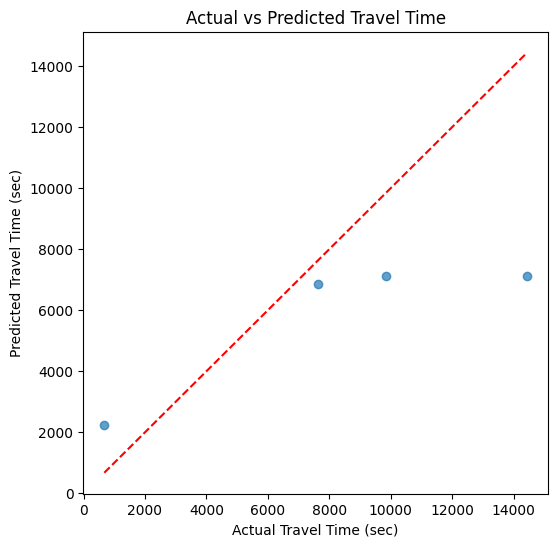

In [ ]:
pdf = predictions.select("travel_time_sec", "prediction").toPandas()

plt.figure(figsize=(6,6))
plt.scatter(pdf["travel_time_sec"], pdf["prediction"], alpha=0.7)
plt.plot([pdf["travel_time_sec"].min(), pdf["travel_time_sec"].max()],
         [pdf["travel_time_sec"].min(), pdf["travel_time_sec"].max()],
         color='red', linestyle='--')
plt.xlabel("Actual Travel Time (sec)")
plt.ylabel("Predicted Travel Time (sec)")
plt.title("Actual vs Predicted Travel Time")
plt.show()


# Data Streaming

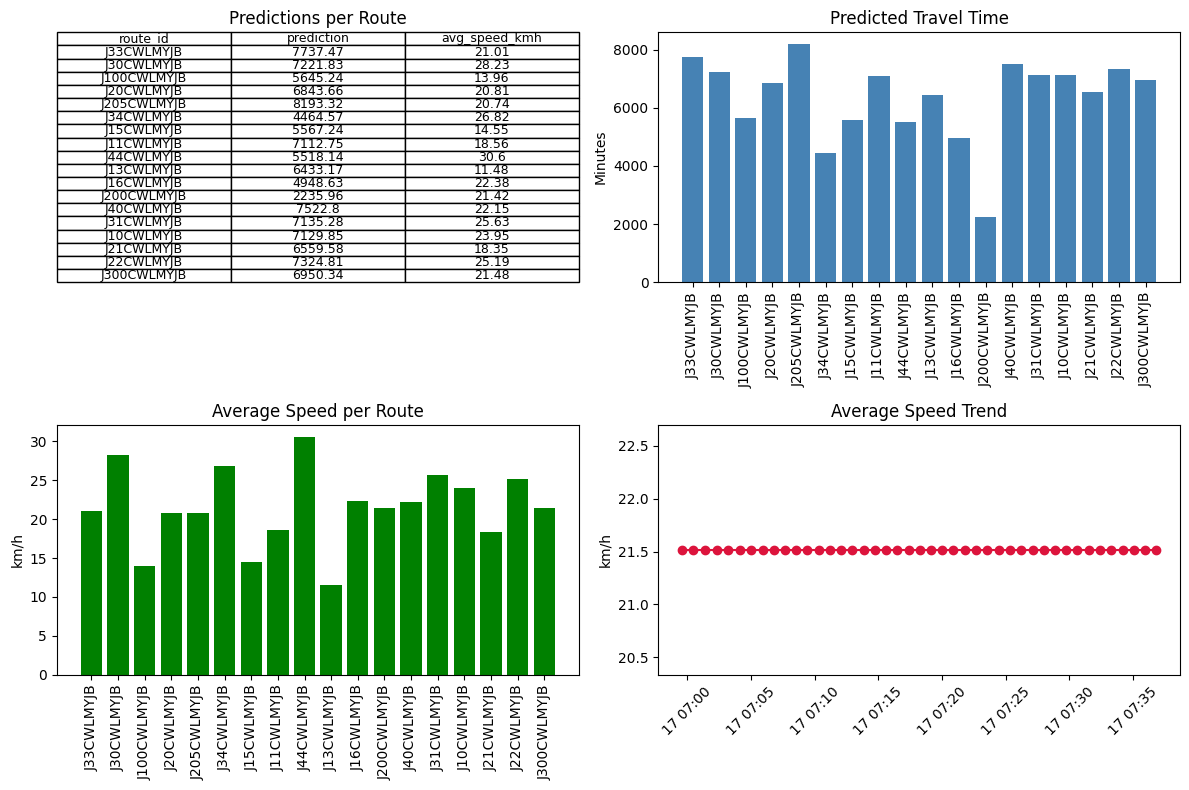

/tmp/ipython-input-1115941684.py:19: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  datetime.utcnow(),
ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/py4j/clientserver.py", line 535, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/socket.py", line 720, in readinto
    return self._sock.recv_into(b)
           ^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt


KeyboardInterrupt: 

In [ ]:
import time, threading
from IPython import display
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, lag, unix_timestamp, avg, when
from pyspark.ml.feature import VectorAssembler
import builtins # Import builtins

spark = SparkSession.builder.appName("Bus_Travel_Time_Dashboard").getOrCreate()
print("Spark session created successfully.")

# History untuk trend chart
trend_history = []

def update_dashboard():
    global trend_history

    # Fetch transport
    try:
        rows = fetch_gtfs_mybas_johor()
        if not rows: # Add check for empty rows
            print("No bus data fetched. Skipping dashboard update.")
            return
        df_new = spark.createDataFrame(rows, df_transport.schema)
    except Exception as e:
        print("Error fetching bus data:", e)
        return

    # 2️Fetch weather
    lats = [r[3] for r in rows]
    lons = [r[4] for r in rows]

    # Check if lats is empty to prevent ZeroDivisionError
    if not lats:
        print("No valid coordinates to calculate average. Skipping weather fetch.")
        return

    avg_lat = builtins.sum(lats)/len(lats) # Use builtins.sum
    avg_lon = builtins.sum(lons)/len(lons) # Use builtins.sum
    weather_row = [fetch_weather(avg_lat, avg_lon)]
    df_new_weather = spark.createDataFrame(weather_row, df_weather.schema)

    df_weather_clean = df_new_weather \
      .withColumnRenamed("timestamp","weather_timestamp") \
      .select(
          "weather_timestamp",
          "temperature",
          "wind",
          "precipitation"
      )



    # Join
    df_join = df_new.join(
        df_weather_clean,
        abs(
            unix_timestamp(df_new.timestamp) -
            unix_timestamp(df_weather_clean.weather_timestamp)
        ) <= 300,
        "left"
    )

    # Hitung prev_lat/lon/time, distance, delta_time, speed
    w = Window.partitionBy("trip_id").orderBy("timestamp")
    df_prep = df_join.withColumn("prev_lat", lag("lat").over(w)) \
                     .withColumn("prev_lon", lag("lon").over(w)) \
                     .withColumn("prev_time", lag("timestamp").over(w))

    df_dist = df_prep \
    .withColumn(
        "distance_km",
        haversine(
            col("prev_lat"), col("prev_lon"),
            col("lat"), col("lon")
        )
    )

    df_time = df_dist \
    .withColumn(
        "delta_time_sec",
        unix_timestamp("timestamp") - unix_timestamp("prev_time")
    )

    df_speed = df_time.withColumn(
        "speed_kmh",
        col("distance_km") / (col("delta_time_sec") / 3600)
    ).drop('speed')

    # Aggregate per rute
    df_route = df_speed_clean.groupBy("route_id") \
      .agg(
          sum("delta_time_sec").alias("travel_time_sec"),
          avg("speed_kmh").alias("avg_speed_kmh"),
          avg("temperature").alias("avg_temp"),
          avg("wind").alias("avg_wind"),
          avg("precipitation").alias("avg_precip")
      )


    # Prediksi
    assembler = VectorAssembler(
        inputCols=["avg_speed_kmh", "avg_temp", "avg_wind", "avg_precip"],
        outputCol="features"
    )

    df_features = assembler.transform(df_route)
    predictions = model.transform(df_features)

    pdf = predictions.select(
        "route_id",
        "prediction",
        "avg_speed_kmh",
    ).toPandas()

    display.clear_output(wait=True)
    # Tambahkan ke trend_history
    trend_history.append({"time": pd.Timestamp.now(), "avg_speed": pdf["avg_speed_kmh"].mean()})
    trend_df = pd.DataFrame(trend_history)

    # Update dashboard
    display.clear_output(wait=True)
    fig, axes = plt.subplots(2,2, figsize=(12,8))

    # Tabel prediksi
    axes[0,0].axis('off')

    table = axes[0,0].table(
        cellText=pdf.round(2).values,
        colLabels=pdf.columns,
        loc='center',
        cellLoc='center',
        bbox=[0, 0, 1, 1]
    )

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 1.5)

    axes[0,0].set_title("Predictions per Route")

    # Bar chart prediksi
    axes[0,1].bar(pdf["route_id"], pdf["prediction"], color='steelblue')
    axes[0,1].set_title("Predicted Travel Time")
    axes[0,1].set_ylabel("Minutes")
    axes[0,1].tick_params(axis='x',rotation=90)

    # Speed chart
    axes[1,0].bar(pdf["route_id"], pdf["avg_speed_kmh"], color='green')
    axes[1,0].set_title("Average Speed per Route")
    axes[1,0].set_ylabel("km/h")
    axes[1,0].tick_params(axis='x',rotation=90)

    # Trend over time
    axes[1,1].plot(trend_df["time"], trend_df["avg_speed"], marker='o', color='crimson')
    axes[1,1].set_title("Average Speed Trend")
    axes[1,1].set_ylabel("km/h")
    axes[1,1].tick_params(axis='x',rotation=45)

    plt.tight_layout()
    display.display(fig)
    plt.close(fig)

# Loop batch update setiap 30 detik
while True:
    update_dashboard()
    time.sleep(30)


# Interpretasi Setiap Grafik
1. Grafik Pertama : Tabel “Predictions per Route” berfungsi sebagai ringkasan numerik hasil prediksi model per rute, interpretasi:

- Rute dengan kecepatan rata-rata rendah (misalnya <10 km/jam) memiliki waktu tempuh prediksi yang lebih tinggi dibandingkan rute dengan kecepatan di atas 25 km/jam

2. Grafik kedua : Grafik menunjukkan variasi waktu tempuh prediksi yang signifikan antar rute bus dimana Tidak semua rute memiliki waktu tempuh yang seragam

- Ada rute yang secara konsisten diprediksi > 230 menit, menunjukkan potensi:

- kemacetan

- panjang rute

- kondisi operasional kurang optimal

3. Grafik ketiga, Bar Chart “Average Speed per Route”

Kecepatan rata-rata menunjukkan korelasi negatif terhadap waktu tempuh yang diprediksi.

4. Grafik keempat

- Garis hampir datar

Artinya:

kondisi lalu lintas relatif stabil

tidak ada perubahan signifikan dalam periode pengamatan



